In [1]:
from collections import namedtuple
from astropy.io.votable import from_table, parse_single_table
from astropy.io import fits
from astropy.table import QTable, Column
from astropy.convolution import convolve
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from RadioAbsTools import cube_tools, spectrum_tools
from astropy.wcs import WCS
import regions
from astropy.coordinates import SkyCoord

sns.set()

In [2]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

## Corrected column density
Calculate any stats that depend on the \tau(v) for each spectrum. This includes the corrected column density, equivalent width and the density weighted mean spin temperature. The output of this notebook will be a set of figures for these values as well as an augmented specra catalogue.

### Table of Contents

* [Produce augmented spectra table](#Produce-augmented-spectra-table)
* [Corrected Column Density and R_HI](#Corrected-Column-Density-and-R_HI)
* [Comparison to Galactic Surveys](#Comparison-to-Galactic-Surveys)
* [Equivalent Width and the Kanekar, Braun and Roy 2011 Result](#Equivalent-Width-and-the-Kanekar,-Braun-and-Roy-2011-Result)
* [Mean Spin Temperatures](#Mean-Spin-Temperatures)
* [Cool gas fraction](#Cool-gas-fraction)
* [Effects of Optical Depth Noise](#Effects-of-Optical-Depth-Noise)
* [Comparison plots of the effect of smoothing](#Comparison-plots-of-the-effect-of-smoothing)
* [Scratch](#Scratch)

### Produce augmented spectra table

In [3]:

# Constants

c0 = 1.823 * 10**18

In [4]:
def find_emission_window(abs_spec, vel_range):
    em_idxes = np.where((abs_spec['em_mean'] >= 3) & # K
                        (abs_spec['velocity']/1e3 >= vel_range[0] ) & 
                        (abs_spec['velocity']/1e3 <= vel_range[1]) )
    #print (em_idxes, len(em_idxes[0]), em_idxes[0][0], em_idxes[0][-1])
    if len(em_idxes[0]) < 2:
        return None
    return np.array([em_idxes[0][0], em_idxes[0][-1]])
    
def process_spectrum(source, spectra_folder, vel_range=(75, 250), plot=False, smooth_thresh=0.04, sigma_clip=1, use_em_filter=True, report_settings=False):
    """
    Produce column density correction measurements for a spectrum. The spectrum will be read in and the emission 
    and absorption compared at each velocity to produce a correction to the 'thin' optical depth assumption 
    column density measured in the emission spectrum.
    """
    if report_settings:
        print ('Spectrum settings: Em box:{}, Smoothing with noise > {}, Sigma Clip: < {} sigma, velocity {} - {} km/s'.format(
                use_em_filter, smooth_thresh, sigma_clip, vel_range[0], vel_range[1]))
    comp_name = source['comp_name']
    abs_spec_filename = '{}/{}_spec.vot'.format(spectra_folder, comp_name)
    abs_spec_votable = parse_single_table(abs_spec_filename)
    abs_spec = abs_spec_votable.to_table()
    abs_velocity = abs_spec['velocity']
    vel_filter = (abs_velocity/1e3 >= vel_range[0] ) & (abs_velocity/1e3 <= vel_range[1])
    optical_depth = np.asarray(abs_spec['opacity'])
    emission = abs_spec['em_mean']
    
    if use_em_filter:
        em_window = find_emission_window(abs_spec, vel_range)
        if em_window is not None:
            vel_filter = (abs_velocity >= abs_velocity[em_window[0]] ) & (abs_velocity <= abs_velocity[em_window[1]])
        else:
            vel_filter = np.full(abs_velocity.shape, False)
    else:
        em_window = None

    #print (em_window)
        vel_filter = (abs_velocity >= abs_velocity[em_window[0]] ) & (abs_velocity <= abs_velocity[em_window[1]])
        #axs[0].vlines(abs_velocity[em_window]/1e3, 0, 1, ls=':')
    num_chan = np.sum(vel_filter)
    # TODO: Handle case of no window foundwith em > 3K

    if source['sd_cont'] > smooth_thresh:
        hann_kernel = np.hanning(5)
        optical_depth = convolve(abs_spec['opacity']*abs_spec['velocity'].unit, hann_kernel)

    corr_od = np.array(optical_depth)

    if sigma_clip:
        noise_filter = (1-optical_depth)< sigma_clip*abs_spec['sigma_opacity']
        #np.sum(noise_filter)
        corr_od[noise_filter] = 1
    
    sat_filter = optical_depth <= 0
    corr_od[sat_filter] = abs_spec['sigma_opacity'][sat_filter]

    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        fig.suptitle("Correction for " + comp_name)
        axs[0].plot(abs_velocity/1e3, abs_spec['opacity'], label="Original")
        axs[0].plot(abs_velocity/1e3, corr_od, label="Trimmed")
        axs[0].legend()
        axs[0].set_xlabel('Velocity (km/s)')
        axs[0].set_ylabel(r'exp($-\tau$)')
        axs[0].set_xlim(vel_range)
        axs[0].set_title('Absorption')
        if em_window is not None:
            axs[0].vlines(abs_velocity[em_window]/1e3, 0, 1, ls=':')



    ew = np.sum(-1*np.log(corr_od[vel_filter]))

    n_h = c0 * emission
    no_abs_filter = (corr_od == 1)
    
    # Apply abs correction to GASKAP column density
    corr_nh = c0 * -1*np.log(corr_od)*emission / (1-corr_od)
    corr_nh[no_abs_filter] = c0*emission[no_abs_filter] # Fixes the div by 0 channels where there is no absorption
    
    
    img_nh = source['nh_gass']
    tot_nh = np.sum(n_h[vel_filter])
    e_tot_nh = c0 * np.sqrt(np.sum(abs_spec['em_std'][vel_filter]**2))

    tot_corr_nh = np.sum(corr_nh[vel_filter])
    r_hi = tot_corr_nh / tot_nh
    #print ("image n_h = {:.3E} calc n_h = {:.3E} corr n_h= {:.3E} R_HI_corr={:.3f} R_HI_calc={:.3f}".format(img_nh, tot_nh, tot_corr_nh, r_hi, tot_nh/img_nh))

    if plot:
        axs[1].plot(abs_velocity/1e3, n_h, label="Uncorrected")
        axs[1].plot(abs_velocity/1e3, corr_nh, label="Corrected")
        axs[1].legend()
        axs[1].set_xlabel('Velocity (km/s)')
        axs[1].set_ylabel('Column Density')
        axs[1].set_xlim(vel_range)
        axs[1].set_title('Column Density Correction')
        if em_window is not None:
            axs[1].vlines(abs_velocity[em_window]/1e3, 0, np.max(corr_nh), ls=':')


    mean_ts = np.sum(emission[vel_filter]) / np.sum(1-corr_od[vel_filter])

    mean_cont, sd_cont = spectrum_tools.get_mean_continuum(abs_velocity/1000, optical_depth, -100, -60)
    
    # Correction fraction from Dickey et al 2000
    with np.errstate(divide='ignore',invalid='ignore'):
        f_v = -1*np.log(corr_od) / (1-corr_od)
        f_v = np.nan_to_num(f_v, nan=1)
    
    if plot:
        axs[2].plot(abs_velocity/1e3, f_v, label="f_v")
        axs[2].set_xlabel('Velocity (km/s)')
        axs[2].set_ylabel('f$_v$')
        axs[2].set_xlim(vel_range)
        axs[2].set_title('Correction factor')
        if em_window is not None:
            axs[2].vlines(abs_velocity[em_window]/1e3, 1, np.max(f_v), ls=':')


    f_int_v = np.sum(f_v[vel_filter]*emission[vel_filter])/np.sum(emission[vel_filter])

    SpectraStats = namedtuple('SpectraStats', 
                              'img_nh,tot_uncorr_nh,e_tot_uncorr_nh,tot_corr_nh,r_hi,ew,mean_ts,sd_cont,f_int_v,num_chan')
    
    return SpectraStats(img_nh, tot_nh, e_tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v, num_chan)


def read_beam_power(spectra_table):
    power_pat = fits.open('sb10944/SMC_PB_pattern_full.fits')
    power_wcs = WCS(power_pat[0].header).celestial
    pix_pos = power_wcs.wcs_world2pix(spectra_table['ra'], spectra_table['dec'], 0)
    power_vals = power_pat[0].data[0, 0, pix_pos[1].astype(int), pix_pos[0].astype(int)]
    return power_vals

def read_spectra_table(noise_limit=0.3, beam_power_min=0.8):
    spectra_table = parse_single_table('sb10944/v3a/askap_spectra.vot').to_table()
    
    spectra_table.add_column(Column(name='beam_power', data=read_beam_power(spectra_table), 
                                    description='Fraction of primary beam power at this location'))
    
    num_rows = len(spectra_table)
    # Exclude the really noisy spectra
    spectra_table = spectra_table[spectra_table['sd_cont'] < noise_limit]
    spectra_table = spectra_table[spectra_table['beam_power'] > beam_power_min]
    num_excluded = num_rows - len(spectra_table)
    print ("Read {} rows, excluded {} due to noise, leaving {} rows".format(num_rows, num_excluded, len(spectra_table)))


    spectra_table.rename_column('n_h', 'nh_gass')
    
    
    return spectra_table


Read 373 rows, excluded 144 due to noise, leaving 229 rows
Spectrum settings: Em box:True, Smoothing with noise > 20, Sigma Clip: < -20 sigma, velocity 75 - 250 km/s
image n_h = 3.690E+21 GASKAP uncorr n_h = 3.068E+21 corr n_h= 4.385E+21 R_HI_corr=1.429 GASKAP/GASS N_H=0.831 f_int(D00)=1.429 ew=1.535651E+01 <T_S>=215.318 old sd_cont=0.025 new sd_cont=0.025 chans=45


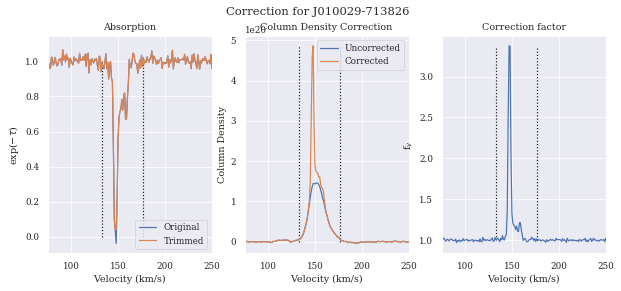

In [5]:
spectra_table = read_spectra_table(noise_limit=0.3)


comp_name = 'J010029-713826'
source = spectra_table[spectra_table['comp_name'] == comp_name]
#img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source[0], 'sb10944/v3a/spectra', plot=True, sigma_clip=-20, use_em_filter=False)
spectra_stats = process_spectrum(source[0], 'sb10944/v3a/spectra', plot=True, sigma_clip=-20, smooth_thresh=20, use_em_filter=True, report_settings=True)
plt.savefig('figures/column_density_processing.png')
print ("image n_h = {:.3E} GASKAP uncorr n_h = {:.3E} corr n_h= {:.3E} R_HI_corr={:.3f} GASKAP/GASS N_H={:.3f} f_int(D00)={:.3f} ew={:3E} <T_S>={:.3f} old sd_cont={:.3f} new sd_cont={:.3f} chans={}".format(
    spectra_stats.img_nh, spectra_stats.tot_uncorr_nh, spectra_stats.tot_corr_nh, spectra_stats.r_hi, spectra_stats.tot_uncorr_nh/spectra_stats.img_nh, spectra_stats.f_int_v, spectra_stats.ew, 
    spectra_stats.mean_ts, source['sd_cont'][0],spectra_stats.sd_cont, spectra_stats.num_chan))


In [6]:

def add_column_density_to_spectra_table():
    all_nh = []
    all_corr_nh = []
    all_img_nh = []
    all_r_hi = []
    all_ew = []
    all_mean_ts = np.empty((0))
    all_sd_cont = np.empty((0))
    all_f_int = np.empty((0))
    all_num_chan = []
    all_e_tot_uncorr_nh = []


    for idx, source in enumerate(spectra_table):
        if idx % 50 == 0:
            print ('processing record {} of {}'.format(idx+1, len(spectra_table)))
        #img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source, 'sb10944/v3a/spectra', sigma_clip=-20, use_em_filter=False)
        spectra_stats = process_spectrum(source, 'sb10944/v3a/spectra', sigma_clip=-20, smooth_thresh=20, use_em_filter=True, report_settings=idx==0)
        all_nh.append(spectra_stats.tot_uncorr_nh)
        all_e_tot_uncorr_nh.append(spectra_stats.e_tot_uncorr_nh)
        all_corr_nh.append(spectra_stats.tot_corr_nh)
        all_img_nh.append(spectra_stats.img_nh)
        all_r_hi.append(spectra_stats.r_hi)
        all_ew.append(spectra_stats.ew)
        all_mean_ts = np.append(all_mean_ts, spectra_stats.mean_ts)
        all_sd_cont = np.append(all_sd_cont, spectra_stats.sd_cont)
        all_f_int = np.append(all_f_int, spectra_stats.sd_cont)
        all_num_chan.append(spectra_stats.num_chan)


    all_nh = np.array(all_nh)
    all_ew = np.array(all_ew)
    all_num_chan = np.array(all_num_chan)
    all_e_tot_uncorr_nh = np.array(all_e_tot_uncorr_nh)

    spectra_table.add_column(Column(name='nh_uncorr', data=all_nh, unit=u.cm**-2, 
                                description='Uncorrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='e_nh_uncorr', data=all_e_tot_uncorr_nh, unit=u.cm**-2, 
                                description='Uncertainty in the uncorrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='nh_corr', data=all_corr_nh, unit=u.cm**-2, 
                                    description='Absorption corrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='r_hi', data=all_r_hi, 
                                    description='Ratio of uncorrected to corrected column density'))
    spectra_table.add_column(Column(name='f_int', data=all_r_hi, 
                                    description='Dickey et al 2000 ratio of uncorrected to corrected column density'))
    spectra_table.add_column(Column(name='mean_ts', data=all_mean_ts, 
                                    description='Density-weighted mean spin temperature'))
    spectra_table.add_column(Column(name='ew', data=all_ew, unit=u.km/u.s,
                                    description='Integral of absoprtion (tau) across the SMC velocity range'))
    spectra_table.add_column(Column(name='num_chan', data=all_num_chan, 
                                    description='Number of chanels in the emission box used for column density etc analysis.'))


    
    filename = 'gaskap_smc_spectra.vot'
    spectra_table.write(filename, table_id='gaskap_smc_spectra', format='votable', overwrite=True)
    print ('Wrote augmented spectra table to', filename)

    
add_column_density_to_spectra_table()


#nh_table = QTable([spectra_table['comp_name'], spectra_table['ra'], spectra_table['dec'], all_img_nh, all_nh, all_corr_nh, 
#                   all_r_hi, spectra_table['peak_tau'], spectra_table['e_peak_tau'], all_ew],
#                  names=('comp_name', 'ra', 'dec', 'nh_img', 'nh', 'nh_corr', 'r_hi', 'peak_tau', 'e_peak_tau', 'ew')
#                 )
#nh_table.write('source_nh.vot', table_id='source_nh', format='votable', overwrite=True)

processing record 1 of 229
Spectrum settings: Em box:True, Smoothing with noise > 20, Sigma Clip: < -20 sigma, velocity 75 - 250 km/s
processing record 51 of 229
processing record 101 of 229
processing record 151 of 229
processing record 201 of 229
Wrote augmented spectra table to gaskap_smc_spectra.vot


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/astropy/table/column.py:222: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)


### Define filters

In [42]:
smc_filter = spectra_table['nh_gass'] >= 2E21

smc_reg = regions.ds9.read.read_ds9('smc-regions.reg')
bar = smc_reg[0]
wing = smc_reg[1]

header = fits.getheader('SMC_askap_parkes_wsclean_PBC_K.fits')
w = WCS(header)

p = SkyCoord(spectra_table['ra'], spectra_table['dec'], frame='fk5')
is_wing = wing.contains(p, w) & smc_filter
is_bar = bar.contains(p, w) & smc_filter

In [43]:
smc_hi_table = spectra_table[smc_filter]

smc_noise = spectra_table[smc_filter]['sd_cont']
smc_very_low_noise_filter = smc_noise < 0.04
smc_lower_noise_filt = smc_noise <= 0.1

# Detections including splits by different regions
detections = spectra_table['has_other_abs']

wing_det = is_wing & detections
bar_det = is_bar & detections

non_wing_det = (~is_wing) & detections
other_det = ~(is_wing | is_bar) & detections

non_detect = ~detections & (spectra_table['sd_cont'] < 0.1)

very_low_noise_filter = spectra_table['sd_cont'] < 0.04
low_noise_filter = (spectra_table['sd_cont'] >= 0.04) & (spectra_table['sd_cont'] < 0.1)
mid_noise_filter = (spectra_table['sd_cont'] >= 0.1) & (spectra_table['sd_cont'] < 0.25)
high_noise_filter = (spectra_table['sd_cont'] >= 0.25)



### Corrected Column Density and R_HI

In [9]:
avg_rhi = np.average(spectra_table['r_hi'][smc_filter])
print ("Mean R_HI is {:.3f} for {} SMC sources".format(avg_rhi, np.sum(smc_filter)))



Mean R_HI is 1.126 for 84 SMC sources


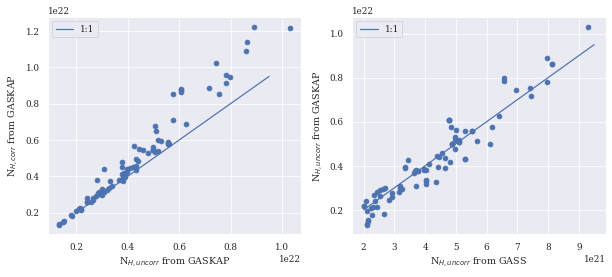

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

nh_range = np.linspace(2,9.5)*1E21

axs[0].scatter(smc_hi_table['nh_uncorr'], smc_hi_table['nh_corr'])

axs[0].plot(nh_range, nh_range, label='1:1')
axs[0].set_xlabel(r'N$_{H,uncorr}$ from GASKAP')
axs[0].set_ylabel(r'N$_{H,corr}$ from GASKAP')
axs[0].legend()

axs[1].scatter(smc_hi_table['nh_gass'], smc_hi_table['nh_uncorr'])
axs[1].plot(nh_range, nh_range, label='1:1')
axs[1].set_xlabel(r'N$_{H,uncorr}$ from GASS')
axs[1].set_ylabel(r'N$_{H,uncorr}$ from GASKAP')
axs[1].legend()

fig.savefig('figures/column_density_correction.png', bbox_inches='tight')


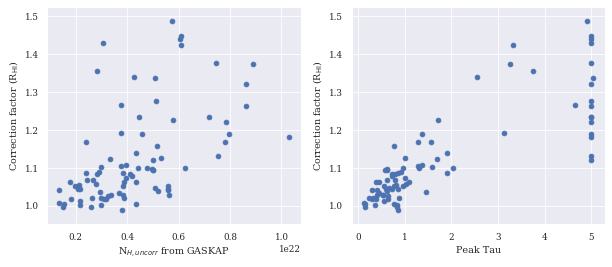

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(smc_hi_table['nh_uncorr'], smc_hi_table['r_hi'])
axs[0].set_xlabel(r'N$_{H,uncorr}$ from GASKAP')
axs[0].set_ylabel(r'Correction factor (R$_{\rm HI}$)')

axs[1].scatter(smc_hi_table['peak_tau'], smc_hi_table['r_hi'])
axs[1].set_xlabel('Peak Tau')
axs[1].set_ylabel(r'Correction factor (R$_{\rm HI}$)')

fig.savefig('figures/column_density_correction_factor.png', bbox_inches='tight')


Text(0.5, 1.0, 'Column Density distribution')

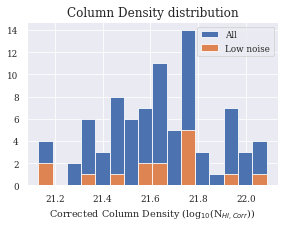

In [46]:
log_nh_corr = np.log10(smc_hi_table['nh_corr'])

fig, ax = plt.subplots(1,1, figsize=(4.5,3))
ax.set_xlabel(r'Corrected Column Density (log$_{10}$(N$_{HI,Corr}$))')

hist, bins, patches = plt.hist(log_nh_corr, bins=16, label='All')
plt.hist(log_nh_corr[smc_very_low_noise_filter], bins=bins, label='Low noise')
plt.gca().legend()
ax.set_title('Column Density distribution', size=12)



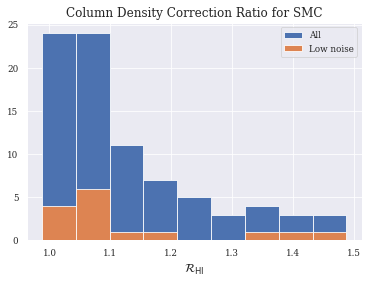

In [47]:
hist, bins, patches = plt.hist(smc_hi_table['r_hi'], bins=9, label='All')
plt.hist(smc_hi_table['r_hi'][smc_very_low_noise_filter], bins=bins, label='Low noise')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'$\mathcal{R}_{\rm HI}$', size=12)
ax.set_title('Column Density Correction Ratio for SMC', size=12)
ax.legend()
plt.savefig('figures/r_hi_hist_smc.png', bbox_inches='tight')

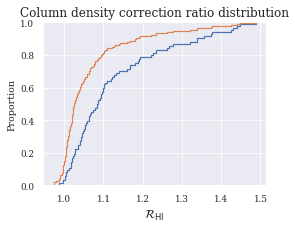

In [41]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ecdf = sns.ecdfplot(x=smc_hi_table['r_hi'], complementary=False, ax=ax)#, legend=False)
ecdf = sns.ecdfplot(x=spectra_table['r_hi'], complementary=False, ax=ax)#, legend=False)

ax.set_xlabel(r'$\mathcal{R}_{\rm HI}$', size=12)

ax.set_title('Column density correction ratio distribution', size=12)

plt.savefig('figures/r_hi_cdf_smc.png', bbox_inches='tight')


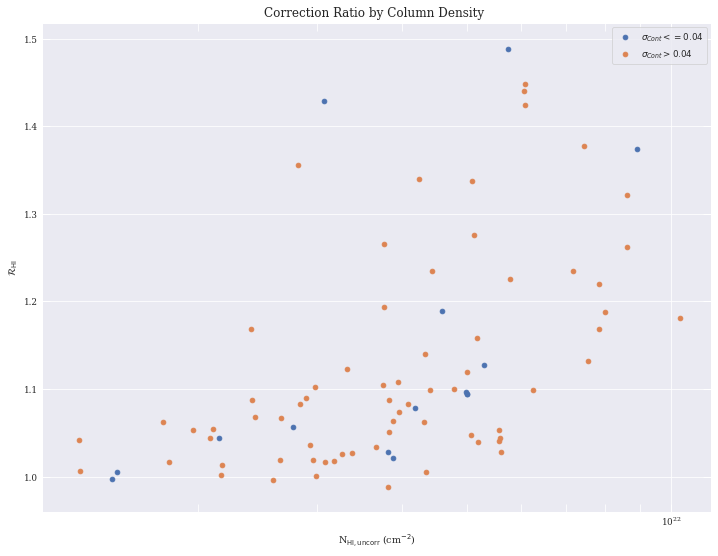

In [48]:

fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(smc_hi_table['nh_uncorr'][smc_very_low_noise_filter], smc_hi_table['r_hi'][smc_very_low_noise_filter], label='$\sigma_{Cont} <= 0.04$')
ax.scatter(smc_hi_table['nh_uncorr'][~smc_very_low_noise_filter], smc_hi_table['r_hi'][~smc_very_low_noise_filter], label='$\sigma_{Cont} > 0.04$')

#ax.scatter(smc_hi_table['nh_img'], smc_hi_table['r_hi'], label='GASS N$_{H}$')



ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_xlim(1e21, 2e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(0.005, 300)
#ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
ax.set_xlabel(r'N$_{\rm HI, uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\mathcal{R}_{\rm HI}$')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=8)
ax.set_title('Correction Ratio by Column Density ', size=12)


ax.legend()
fig.savefig('figures/nh_rhi.png', bbox_inches='tight')

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


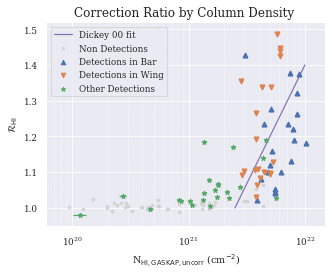

In [105]:

#fig, ax = plt.subplots(1,1, figsize=(6,4.5))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))



log_n_h = np.log10(spectra_table['nh_uncorr'])
e_log_n_h = log_n_h*(spectra_table['e_nh_uncorr']/spectra_table['nh_uncorr'])
#print (e_log_n_h)

ax.scatter(spectra_table['nh_uncorr'][non_detect], spectra_table['r_hi'][non_detect], marker='.', color='lightgray', label='Non Detections')
ax.errorbar(spectra_table['nh_uncorr'][non_detect], spectra_table['r_hi'][non_detect], xerr=e_log_n_h[non_detect], fmt=".", color='lightgray')

ax.scatter(spectra_table['nh_uncorr'][bar_det], spectra_table['r_hi'][bar_det], marker='^', label='Detections in Bar')
ax.errorbar(spectra_table['nh_uncorr'][bar_det], spectra_table['r_hi'][bar_det], xerr=spectra_table['e_nh_uncorr'][bar_det], fmt='^')

ax.scatter(spectra_table['nh_uncorr'][wing_det], spectra_table['r_hi'][wing_det], marker='v', label='Detections in Wing')
ax.errorbar(spectra_table['nh_uncorr'][wing_det], spectra_table['r_hi'][wing_det], xerr=spectra_table['e_nh_uncorr'][wing_det], fmt='v')


ax.scatter(spectra_table['nh_uncorr'][other_det], spectra_table['r_hi'][other_det], marker='*', label='Other Detections')
ax.errorbar(spectra_table['nh_uncorr'][other_det], spectra_table['r_hi'][other_det], xerr=spectra_table['e_nh_uncorr'][other_det], fmt='*')



ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(6E19, 1.5E22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(0.005, 300)
#ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
#ax.set_xlabel(r'N$_{\rm HI, uncorr}$ (cm$^{-2}$)')
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\mathcal{R}_{\rm HI}$')
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w')#, length=8)
ax.set_title('Correction Ratio by Column Density ', size=12)
nh_sample = np.linspace(2.5E21, 1E22,1000)
d00_line = 1+0.667*(np.log10(nh_sample)-21.4)
#ax.plot(np.log10(nh_sample), d00_line, label="Dickey 00 fit", c="C4")
ax.plot(nh_sample, d00_line, label="Dickey 00 fit", c="C4")

plt.grid(True, which="major", ls="-")
plt.grid(True, which="minor", ls=":")

ax.legend()
fig.savefig('figures/nh_rhi_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_rhi_detections.pdf', bbox_inches='tight')

### Comparison to Galactic Surveys

In [17]:
hdul = fits.open('reference/integrated_properties_comparison.fits') 
comparison_data = hdul[1].data
comparison_data[:2]
sponge = comparison_data['tags']=='SPONGE'
perseus = comparison_data['tags']=='Perseus'
ht03 = comparison_data['tags']=='HT03'

hdul = fits.open('reference/integrated_properties_mach.fits') 
mach_data = hdul[1].data

In [18]:
print (len(comparison_data), np.sum(sponge), np.sum(perseus), np.sum(ht03), len(mach_data))
comparison_data[:2]

103 43 22 38 44


FITS_rec([( 7.67231523, 0.27895691, 6.97869436, 0.24236883, 185.30870236, 0.49059084, 0.25161932, 0.093621  , 1.09939121, 0.05032406,  12.18140738,  37.00643067, 241.18704832,  1.29800611, '3C327.1A', 'SPONGE'),
          (10.55743079, 0.4258176 , 9.55067593, 0.35956501, 191.86620179, 0.30981149, 0.23484189, 0.08802757, 1.1054119 , 0.05532947, 166.63568163, -33.59591844,  49.74084441, 16.47574959, '4C16.09', 'SPONGE')],
         dtype=(numpy.record, [('nhi_iso', '>f8'), ('nhi_iso_err', '>f8'), ('nhi_thin', '>f8'), ('nhi_thin_err', '>f8'), ('intts_abs', '>f8'), ('intts_abs_err', '>f8'), ('fcnm_abs', '>f8'), ('fcnm_abs_err', '>f8'), ('rhi_abs', '>f8'), ('rhi_abs_err', '>f8'), ('l', '>f8'), ('b', '>f8'), ('ra', '>f8'), ('dec', '>f8'), ('names', 'S9'), ('tags', 'S7')]))

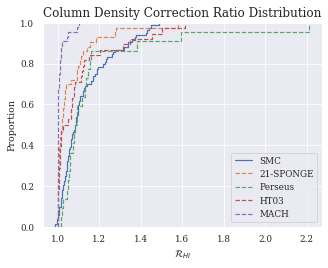

In [57]:
fig, ax = plt.subplots(1,1, figsize=(5,3.75))
rhi = smc_hi_table['r_hi']#[smc_hi_table['has_other_abs']]
ecdf = sns.ecdfplot(x=rhi, complementary=False, ax=ax, legend=False)
for label in ('SPONGE', 'Perseus', 'HT03'):
    comp_filt = comparison_data['tags']==label
    rhi = comparison_data['rhi_abs'][comp_filt].astype('float64')
    sns.ecdfplot(x=rhi, ax=ax, legend=False, ls='--')
sns.ecdfplot(x=mach_data['rhi_abs'].astype('float64'), ax=ax, legend=False, ls='--')

ax.set_xlabel(r'$\mathcal{R}_{HI}$')

ax.set_title('Column Density Correction Ratio Distribution', size=12)
ax.legend(['SMC', '21-SPONGE', 'Perseus', 'HT03', 'MACH'])

plt.savefig('figures/r_hi_cdf_smc_comp.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/r_hi_cdf_smc_comp.pdf', bbox_inches='tight')




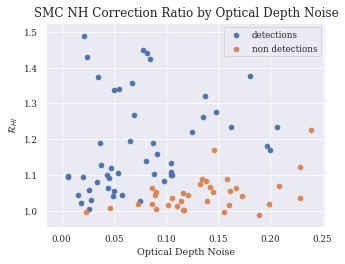

In [55]:
fig, ax = plt.subplots(1,1, figsize=(5,3.75))
rhi = smc_hi_table['r_hi']#[smc_hi_table['has_other_abs']]
sdcont = smc_hi_table['sd_cont']#[smc_hi_table['has_other_abs']]
smc_det = smc_hi_table['has_other_abs']
ax.scatter(sdcont[smc_det], rhi[smc_det], label="detections")
ax.scatter(sdcont[~smc_det], rhi[~smc_det], label="non detections")

ax.set_ylabel(r'$\mathcal{R}_{HI}$')
ax.set_xlabel(r'Optical Depth Noise')
ax.legend()

ax.set_title('SMC NH Correction Ratio by Optical Depth Noise', size=12)

plt.savefig('figures/r_hi_by_noise.png', bbox_inches='tight', dpi=200)

### Equivalent Width and the Kanekar, Braun and Roy 2011 Result

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


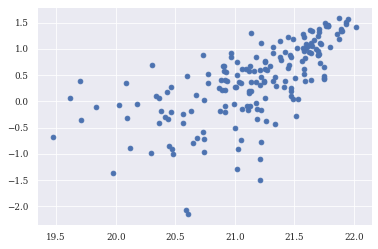

In [21]:
log_ew = np.log10(spectra_table['ew'])
log_nh = np.log10(spectra_table['nh_uncorr'])
plt.scatter(log_nh, log_ew)

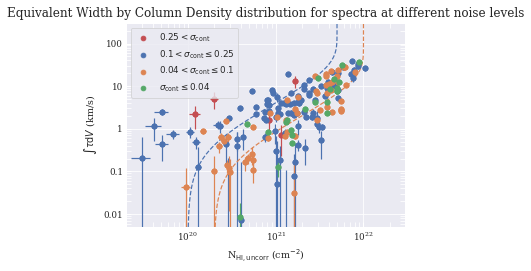

In [59]:

all_nh = spectra_table['nh_uncorr']
all_ew = spectra_table['ew']


tauvals = np.logspace(np.log10(0.005), np.log10(300), 200)
kbr11_lower = 1e20*np.exp(-1*tauvals/20)+5e21*(1-np.exp(-1*tauvals/20))
kbr11_upper = 2e20*np.exp(-1*tauvals/10)+1e22*(1-np.exp(-1*tauvals/10))

# e_nh_uncorr

#fig, ax = plt.subplots(1,1, figsize=(12,9))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))


ax.scatter(all_nh[high_noise_filter], all_ew[high_noise_filter], label=r'$0.25 < \sigma_{\rm cont}$', c='C3')
ax.errorbar(all_nh[high_noise_filter], all_ew[high_noise_filter], yerr=spectra_table['e_peak_tau'][high_noise_filter], fmt="o", c='C3')
ax.errorbar(all_nh[high_noise_filter], all_ew[high_noise_filter], xerr=spectra_table['e_nh_uncorr'][high_noise_filter], fmt="o", c='C3')


ax.scatter(all_nh[mid_noise_filter], all_ew[mid_noise_filter], label=r'$0.1 < \sigma_{\rm cont} \leq 0.25$')
ax.errorbar(all_nh[mid_noise_filter], all_ew[mid_noise_filter], yerr=spectra_table['e_peak_tau'][mid_noise_filter], fmt="o", c='C0')
ax.errorbar(all_nh[mid_noise_filter], all_ew[mid_noise_filter], xerr=spectra_table['e_nh_uncorr'][mid_noise_filter], fmt="o", c='C0')


ax.scatter(all_nh[low_noise_filter], all_ew[low_noise_filter], label=r'$0.04 < \sigma_{\rm cont} \leq 0.1$')
ax.errorbar(all_nh[low_noise_filter], all_ew[low_noise_filter], yerr=spectra_table['e_peak_tau'][low_noise_filter], fmt="o", c='C1')
ax.errorbar(all_nh[low_noise_filter], all_ew[low_noise_filter], xerr=spectra_table['e_nh_uncorr'][low_noise_filter], fmt="o", c='C1')


ax.scatter(all_nh[very_low_noise_filter], all_ew[very_low_noise_filter], label=r'$\sigma_{\rm cont} \leq 0.04$')
ax.errorbar(all_nh[very_low_noise_filter], all_ew[very_low_noise_filter], yerr=spectra_table['e_peak_tau'][very_low_noise_filter], fmt="o", c='C2')
ax.errorbar(all_nh[very_low_noise_filter], all_ew[very_low_noise_filter], xerr=spectra_table['e_nh_uncorr'][very_low_noise_filter], fmt="o", c='C2')


#ax.scatter(all_nh[detection_filter], all_ew[detection_filter], label=r'Detections', c='C4', marker='*', s=100)
#ax.errorbar(all_nh[detection_filter], all_ew[detection_filter], yerr=spectra_table['e_peak_tau'][detection_filter], fmt="*", c='C4')




ax.plot(kbr11_lower, tauvals, ls='--')
ax.plot(kbr11_upper, tauvals, ls='--')

ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(0.005, 300)
ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\int \tau {\rm d}V$ (km/s)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
ax.set_title('Equivalent Width by Column Density distribution for spectra at different noise levels', size=12)


ax.legend()
fig.savefig('figures/nh_ew_kbr11.png', bbox_inches='tight')

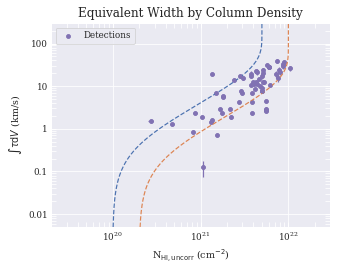

In [78]:

tauvals = np.logspace(np.log10(0.005), np.log10(300), 200)
kbr11_lower = 1e20*np.exp(-1*tauvals/20)+5e21*(1-np.exp(-1*tauvals/20))
kbr11_upper = 2e20*np.exp(-1*tauvals/10)+1e22*(1-np.exp(-1*tauvals/10))

#fig, ax = plt.subplots(1,1, figsize=(12,9))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

ax.scatter(all_nh[detections], all_ew[detections], label=r'Detections', c='C4', s=16)#, marker='*')#, s=60)
ax.errorbar(all_nh[detections], all_ew[detections], yerr=spectra_table['e_peak_tau'][detections], c='C4', fmt='.', ms=5)
ax.errorbar(all_nh[detections], all_ew[detections], xerr=spectra_table['e_nh_uncorr'][detections], c='C4', fmt='.', ms=5)


ax.plot(kbr11_lower, tauvals, ls='--')
ax.plot(kbr11_upper, tauvals, ls='--')

ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(0.005, 300)
ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\int \tau {\rm d}V$ (km/s)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
ax.set_title('Equivalent Width by Column Density', size=12)

ax.legend()

fig.savefig('figures/nh_ew_kbr11_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_ew_kbr11_detections.pdf', bbox_inches='tight')

### Mean Spin Temperatures

Text(0.5, 1.0, 'Distribution of Spin Temperatures')

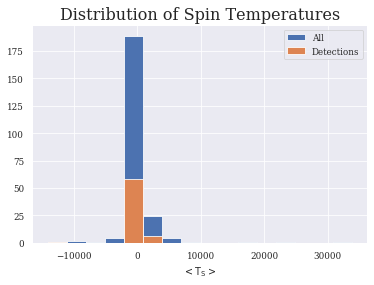

In [24]:

hist, bins, patches = plt.hist(spectra_table['mean_ts'], bins=16, label='All')
plt.hist(spectra_table['mean_ts'][detections], bins=bins, label='Detections')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'$<{\rm T}_{\rm S}>$')
#ax.set_title('Column Density Correction Ratio for SMC')
ax.legend()
#plt.savefig('figures/r_hi_hist_smc.png', bbox_inches='tight')
ax.set_title('Distribution of Spin Temperatures', size=16)


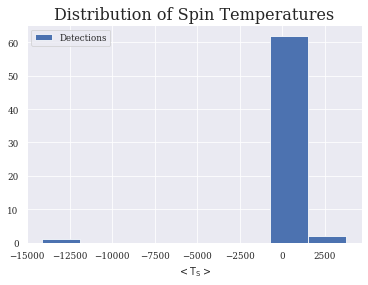

In [25]:
plt.hist(spectra_table['mean_ts'][detections], bins=8, label='Detections')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'$<{\rm T}_{\rm S}>$')
ax.set_title('Distribution of Spin Temperatures', size=16)

ax.legend()
plt.savefig('figures/ts_hist_detections.png', bbox_inches='tight')



Note there are 74 spin temperatures below 1 that are not shown!
>> J010425-742733 [noise=0.251] has T_s=0.000
>> J012336-703232 [noise=0.249] has T_s=-110.385
>> J003530-723655 [noise=0.261] has T_s=-388.876
>> J010524-731518 [noise=0.189] has T_s=-615.773
>> J005503-712107 [noise=0.206] has T_s=-536.789
>> J005115-713058 [noise=0.213] has T_s=-151.264
>> J004027-703513 [noise=0.186] has T_s=-2108.948
>> J012321-703741 [noise=0.186] has T_s=-1006.165
>> J005539-721049 [noise=0.114] has T_s=-9809.049
>> J013134-700042 [noise=0.108] has T_s=-49.899
>> J002631-741314 [noise=0.229] has T_s=-690.790
>> J004555-704646 [noise=0.145] has T_s=0.000
>> J013147-734942 [noise=0.155] has T_s=-660.475
>> J003749-735128 [noise=0.156] has T_s=-822.340
>> J012758-720535 [noise=0.254] has T_s=-406.740
>> J005848-743514 [noise=0.224] has T_s=-204.844
>> J013124-713341 [noise=0.184] has T_s=-198.698
>> J003224-730700 [noise=0.226] has T_s=-222.133
>> J011454-701434 [noise=0.177] has T_s=0.000
>> J012330-7

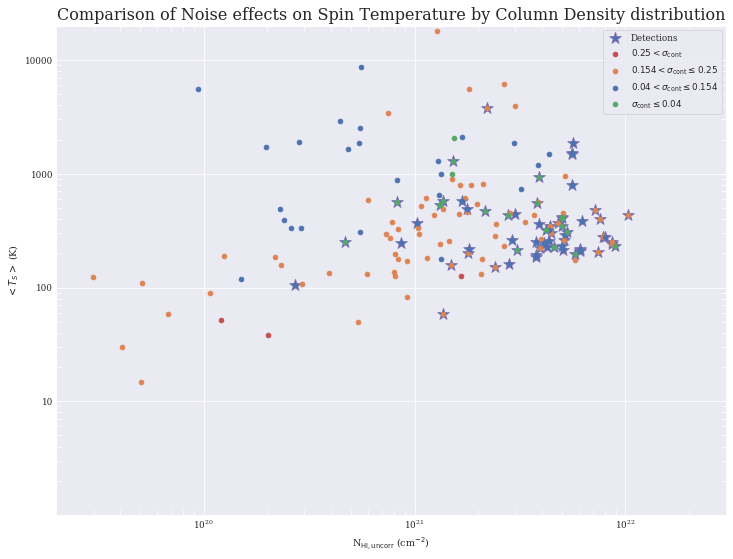

In [26]:
all_mean_ts = spectra_table['mean_ts']
all_nh = spectra_table['nh_uncorr']

fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(all_nh[detections], all_mean_ts[detections], label=r'Detections', c=None, edgecolor='C4', marker='*', s=150)
#ax.scatter(all_nh, all_mean_ts) #, label=r'Detections', c='C4', marker='*', s=100)
ax.scatter(all_nh[high_noise_filter], all_mean_ts[high_noise_filter], label=r'$0.25 < \sigma_{\rm cont}$', c='C3')

ax.scatter(all_nh[mid_noise_filter], all_mean_ts[mid_noise_filter], label=r'$0.154 < \sigma_{\rm cont} \leq 0.25$', c='C1')

ax.scatter(all_nh[low_noise_filter], all_mean_ts[low_noise_filter], label=r'$0.04 < \sigma_{\rm cont} \leq 0.154$', c='C0')

ax.scatter(all_nh[very_low_noise_filter], all_mean_ts[very_low_noise_filter], label=r'$\sigma_{\rm cont} \leq 0.04$', c='C2')



ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(1, 20000)
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$<T_S>$ (K)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
ax.legend()
ax.set_title('Comparison of Noise effects on Spin Temperature by Column Density distribution', size=16)

if np.sum(all_mean_ts<1):    
    print ("Note there are {} spin temperatures below 1 that are not shown!".format(np.sum(all_mean_ts<1)))
    for source in spectra_table[all_mean_ts<1]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))


Note there are 2 spin temperatures below 50 that are not shown!
>> J013134-700042 [noise=0.108] has T_s=-49.899
>> J013701-730415 [noise=0.036] has T_s=-14117.649


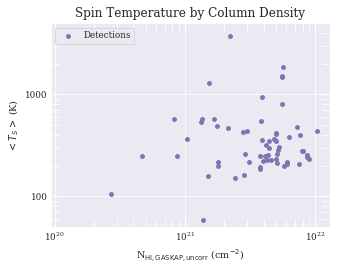

In [104]:
det_mean_ts = spectra_table['mean_ts'][detections]
det_nh = spectra_table['nh_uncorr'][detections]

#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))



ax.scatter(det_nh, det_mean_ts, label=r'Detections', c='C4', s=16) #, marker='*')#, s=100)


ts_floor = 50
ts_ceil = 5000
ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(ts_floor, ts_ceil)
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$<T_S>$ (K)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=8)
ax.set_yticklabels(labels=['', '10', '100', '1000'])
ax.legend(loc='upper left')
ax.set_title('Spin Temperature by Column Density', size=12)

fig.savefig('figures/nh_mean_ts_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_mean_ts_detections.pdf', bbox_inches='tight')


if np.sum(det_mean_ts<ts_floor) > 0:    
    print ("Note there are {} spin temperatures below {} that are not shown!".format(np.sum(det_mean_ts<ts_floor), ts_floor))
    for source in spectra_table[detections][det_mean_ts<ts_floor]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))

        
if np.sum(det_mean_ts>ts_ceil) > 0:    
    print ("Note there are {} spin temperatures above {} that are not shown!".format(np.sum(det_mean_ts>ts_ceil), ts_ceil))
    for source in spectra_table[detections][det_mean_ts>ts_ceil]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))




### Cool gas fraction

f_c = N_c / (N_w + N_c)

n_c ~~ f_c N_unc

<T_s> = T_c / f_c

f_c = T_c / <T_s>

In [29]:
t_cool = 30
fraction_cool = t_cool/spectra_table['mean_ts']

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median mean spin temp SMC 30.00
Median cold gas fraction SMC TC=30K 0.10


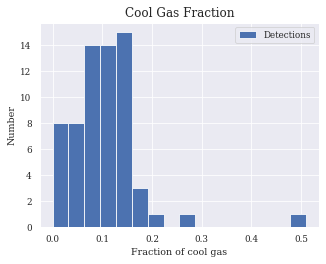

In [101]:
print ("Median mean spin temp SMC {:.2f}".format(t_cool, np.median(spectra_table['mean_ts'][detections])))

print ("Median cold gas fraction SMC TC={}K {:.2f}".format(t_cool, np.median(fraction_cool[detections])))
det_cool_gas_frac = np.array(fraction_cool[detections])
det_cool_gas_frac[det_cool_gas_frac>1] = 1
det_cool_gas_frac[det_cool_gas_frac<0] = 0

all_cool_gas_frac = np.array(fraction_cool)
all_cool_gas_frac[all_cool_gas_frac>1] = 1
all_cool_gas_frac[all_cool_gas_frac<0] = 0


fig, ax = plt.subplots(1,1, figsize=(5,3.75))

#n, bins, patches = ax.hist(all_cool_gas_frac, bins=16, label='All')
ax.hist(det_cool_gas_frac, bins=16, label='Detections', color='C0')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'Fraction of cool gas')
ax.set_ylabel(r'Number')

ax.set_title('Cool Gas Fraction', size=12)

ax.legend()

plt.savefig('figures/fraction_cool_hist_detections.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/fraction_cool_hist_detections.pdf', bbox_inches='tight')


Text(0.5, 1.0, 'Cool Gas Fraction by Column Density distribution')

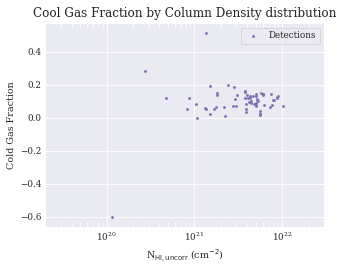

In [103]:
det_nh = spectra_table['nh_uncorr'][detections]

fig, ax = plt.subplots(1,1, figsize=(5,3.75))

ax.scatter(det_nh, fraction_cool[detections], label=r'Detections', c='C4', marker='.', s=16)

ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(ts_floor, ts_ceil)
ax.set_xlabel(r'N$_{\rm HI, uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'Cold Gas Fraction')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
ax.legend()
ax.set_title('Cool Gas Fraction by Column Density distribution', size=12)



### Effects of Optical Depth Noise

Text(0.5, 1.0, 'Comparison of Spin Temperature by Optical Depth Noise')

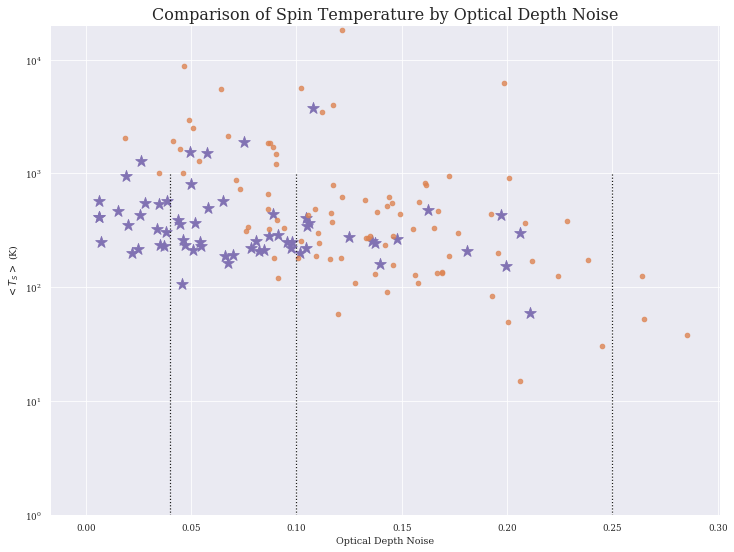

In [32]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'][detections], spectra_table['mean_ts'][detections], label=r'Detections', c='C4', marker='*', s=150)
ax.scatter(spectra_table['sd_cont'][~detections], spectra_table['mean_ts'][~detections], label=r'Non Detections', alpha=0.8, c='C1')



#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise')
ax.set_ylabel(r'$<T_S>$ (K)')

ax.vlines([0.04,0.1,0.25], -50, 1000, ls=':')
#ax.set_ylim(-20, 1000)
#ax.set_xlim(0, 1.4)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
#ax.legend()
ax.set_title('Comparison of Spin Temperature by Optical Depth Noise', size=16)





[0.00614439 0.03718671 0.06822902 0.09927133 0.13031365 0.16135596
 0.19239828 0.22344059 0.25448291 0.28552522]


Text(0.5, 1.0, 'Optical Depth Noise Distribution')

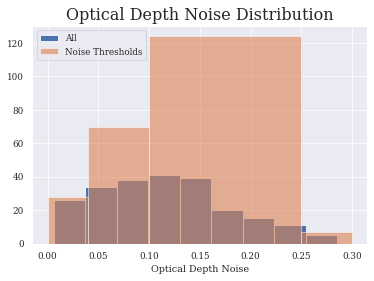

In [33]:
hist, bins, patches = plt.hist(spectra_table['sd_cont'], bins=9, label='All')
plt.hist(spectra_table['sd_cont'], bins=[0,0.04,0.1,0.25,0.3], label='Noise Thresholds', alpha=0.6)
#plt.hist(all_mean_ts[smc_very_low_noise_filter], bins=bins, label='Low noise')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'Optical Depth Noise')

#ax.set_xlabel(r'$<{\rm T}_{\rm S}>$')
print (bins)
ax.legend()
ax.set_title('Optical Depth Noise Distribution', size=16)


Text(0.5, 1.0, 'Comparison of Peak Flux vs Optical Depth Noise')

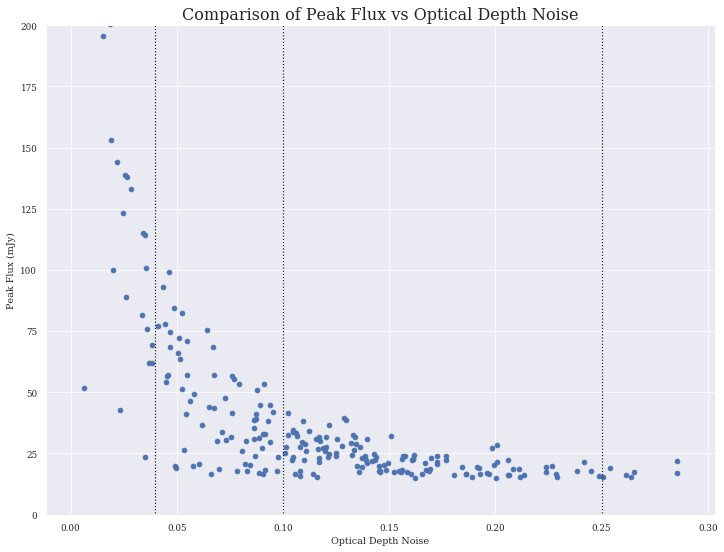

In [34]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'], spectra_table['flux_peak']) #, label=r'Detections', c='C4', marker='*', s=100)


#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise')
ax.set_ylabel(r'Peak Flux (mJy)')

ax.vlines([0.04,0.1,0.25], -50, 1000, ls=':')
ax.set_ylim(0, 200)
#ax.set_xlim(0, 1.4)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
#ax.legend()

ax.set_title('Comparison of Peak Flux vs Optical Depth Noise', size=16)





Text(0.5, 1.0, 'Comparison of Equivalent Width by Optical Depth Noise')

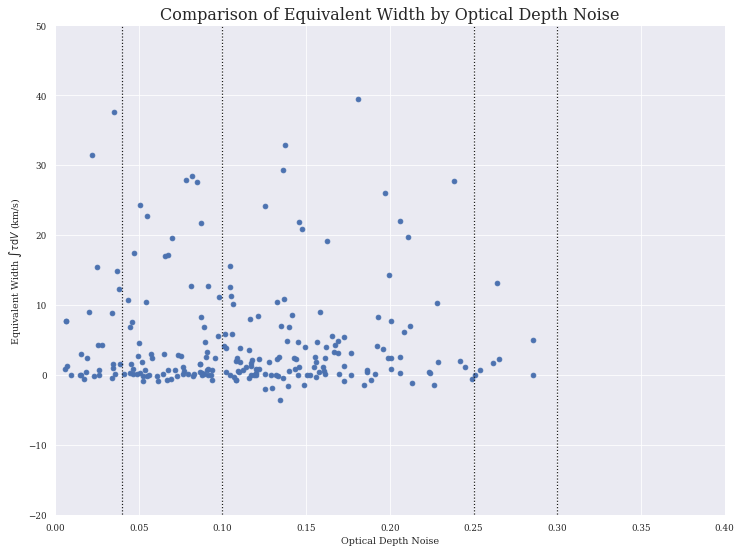

In [35]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'], all_ew) #, label=r'Detections', c='C4', marker='*', s=100)


#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise')
ax.set_ylabel(r'Equivalent Width $\int \tau {\rm d}V$ (km/s)')

ax.vlines([0.04,0.1,0.25, 0.3], -50, 1000, ls=':')
ax.set_ylim(-20, 50)
ax.set_xlim(0, 0.4)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
#ax.legend()

ax.set_title('Comparison of Equivalent Width by Optical Depth Noise', size=16)






### Comparison plots of the effect of smoothing

In [36]:
all_ew_no_smooth = np.empty((0))
all_mean_ts_no_smooth = np.empty((0))
all_sd_cont_no_smooth = np.empty((0))

for idx, source in enumerate(spectra_table):
    if idx % 50 == 0:
        print ('processing record {} of {}'.format(idx+1, len(spectra_table)))
    #img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=5)
    spectra_stats = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=5)

    all_ew_no_smooth = np.append(all_ew_no_smooth, spectra_stats.ew)
    all_mean_ts_no_smooth = np.append(all_mean_ts_no_smooth, spectra_stats.mean_ts)
    all_sd_cont_no_smooth = np.append(all_sd_cont_no_smooth, spectra_stats.sd_cont)


processing record 1 of 229
processing record 51 of 229
processing record 101 of 229
processing record 151 of 229
processing record 201 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


In [37]:
all_ew_alt_smooth = np.empty((0))
all_mean_ts_alt_smooth = np.empty((0))
all_sd_cont_alt_smooth = np.empty((0))

for idx, source in enumerate(spectra_table):
    if idx % 50 == 0:
        print ('processing record {} of {}'.format(idx+1, len(spectra_table)))
    #img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=0.1)
    spectra_stats = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=0.1)

    all_ew_alt_smooth = np.append(all_ew_alt_smooth, spectra_stats.ew)
    all_mean_ts_alt_smooth = np.append(all_mean_ts_alt_smooth, spectra_stats.mean_ts)
    all_sd_cont_alt_smooth = np.append(all_sd_cont_alt_smooth, spectra_stats.sd_cont)



processing record 1 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python

processing record 51 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


processing record 101 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


processing record 151 of 229
processing record 201 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, 'Effect of smoothing on Optical Depth Noise')

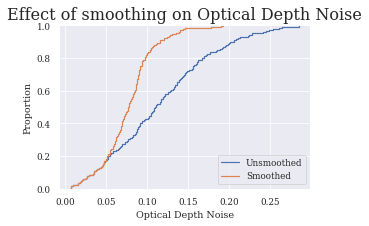

In [38]:
# optical depth noise CDF comparison

fig, ax = plt.subplots(1,1, figsize=(4.5,3))
ecdf = sns.ecdfplot(x=spectra_table['sd_cont'], ax=ax, label='Unsmoothed')#, legend=False)
ecdf = sns.ecdfplot(x=all_sd_cont_alt_smooth, ax=ax, label='Smoothed')#, legend=False)
#ecdf = sns.ecdfplot(x=all_sd_cont_alt_smooth, ax=ax, label='Less Smoothed')#, legend=False)


ax.set_xlabel(r'Optical Depth Noise')
ax.legend()
ax.set_title('Effect of smoothing on Optical Depth Noise', size=16)

Text(0.5, 1.0, 'Effect of smoothing on Equivalent Width')

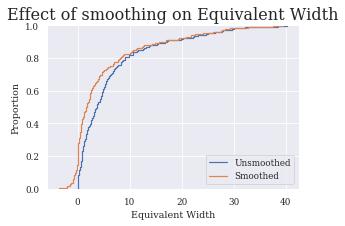

In [39]:
# Equivalent width CDF comparison

fig, ax = plt.subplots(1,1, figsize=(4.5,3))
ecdf = sns.ecdfplot(x=all_ew_no_smooth, ax=ax, label='Unsmoothed')#, legend=False)
ecdf = sns.ecdfplot(x=all_ew, ax=ax, label='Smoothed')#, legend=False)

ax.set_xlabel(r'Equivalent Width')
ax.legend()
ax.set_title('Effect of smoothing on Equivalent Width', size=16)

Text(0.5, 1.0, 'Comparison of the effect of smoothing on Equivalent Width against Optical Depth Noise')

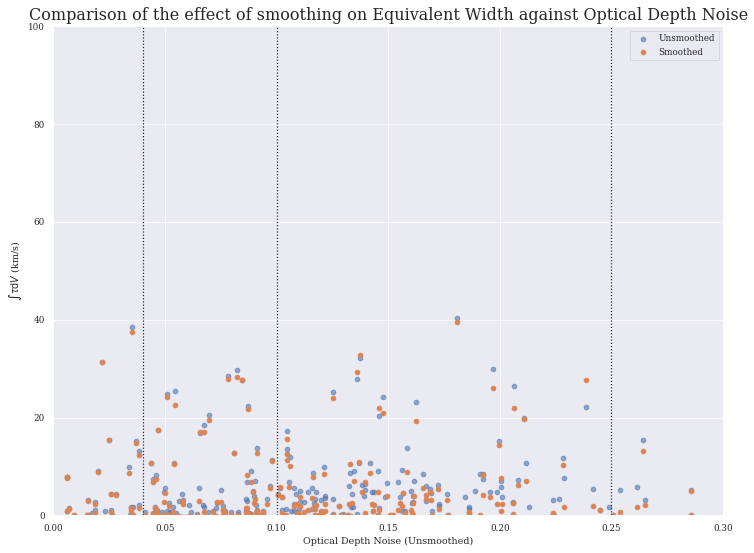

In [40]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'], all_ew_no_smooth, label=r'Unsmoothed', c='C0', alpha=0.6)
ax.scatter(spectra_table['sd_cont'], all_ew, label=r'Smoothed', c='C1')



#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise (Unsmoothed)')
ax.set_ylabel(r'$\int \tau {\rm d}V$ (km/s)')
ax.vlines([0.04,0.1,0.25], -50, 200, ls=':')
ax.set_ylim(0, 100)
ax.set_xlim(0, 0.3)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
ax.legend()
ax.set_title('Comparison of the effect of smoothing on Equivalent Width against Optical Depth Noise', size=16)


### Scratch

In [ ]:
smc_hi_table

In [ ]:
power_pat = fits.open('sb10944/SMC_PB_pattern_full.fits')
power_wcs = WCS(power_pat[0].header).celestial
pix_pos = power_wcs.wcs_world2pix(spectra_table['ra'], spectra_table['dec'], 0)
power_vals = power_pat[0].data[0, 0, pix_pos[1].astype(int), pix_pos[0].astype(int)]
#spectra_table['beam_str'] = power_vals

In [ ]:
power_vals

In [ ]:
regions = Region.read('smc-reg.reg', format='ds9')

In [ ]:
from regions import RegionList

In [ ]:
from regions import ds9
from astropy.coordinates import SkyCoord
smc_reg = regions.ds9.read.read_ds9('smc-reg.reg')
p = SkyCoord(14*u.deg, -73*u.deg, frame='fk5')

In [ ]:
wing = smc_reg[0]
header = fits.getheader('SMC_askap_parkes_wsclean_PBC_K.fits')
w = WCS(header)

In [ ]:
wing.contains(p, w)

In [ ]:
smc_reg